## Máster en Data Science - Series Temporales

# Final Forecast
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

La predicción de la demanda de pasajeros en sistemas de transporte público, como el bus y el metro de Madrid, es crucial para la planificación eficiente y la optimización operativa. En un análisis preliminar, los modelos ETS (Error-Trend-Seasonality) y Theta han demostrado ser los más favorables debido a su capacidad para capturar patrones de tendencia y estacionalidad presentes en los datos históricos. En este contexto, se plantea una nueva evaluación comparativa de estos dos modelos, con el objetivo de seleccionar el que ofrezca el mejor desempeño predictivo y será utilizado para generar las predicciones finales. Esta elección se realizará considerando métricas clave de precisión como MSE, RMSE, MAPE y su capacidad para adaptarse a las características específicas de los datos de demanda de transporte en Madrid.

In [1]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, MeanSquaredError
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from darts.models import Theta, FourTheta, StatsForecastAutoTheta, AutoARIMA, StatsForecastAutoETS
from darts.metrics import mape, smape, mse, rmse
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts import concatenate
from darts.utils.statistics import plot_hist

import warnings
warnings.filterwarnings('ignore')

### Importación de datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [3]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## ETS Model

El modelo ETS (Error-Trend-Seasonality) es un enfoque estadístico para modelar series temporales, que descompone los datos en tres componentes principales: error (E), tendencia (T) y estacionalidad (S). Estos componentes pueden combinarse de manera aditiva o multiplicativa, según las características de la serie. El modelo ETS se basa en ecuaciones recursivas que actualizan las estimaciones de nivel, tendencia y estacionalidad a medida que se introducen nuevos datos, permitiendo una adaptación dinámica. Utiliza suavización exponencial para ponderar más los valores recientes, haciendo que el modelo sea especialmente útil en series con cambios graduales. Además, incorpora un componente de error que puede ser aditivo o multiplicativo, dependiendo de si las fluctuaciones varían de manera constante o proporcional al nivel de la serie. Su flexibilidad lo hace adecuado para capturar diversos patrones en series temporales con estacionalidad regular y tendencias bien definidas.

### Series mensuales ETS

<Figure size 1400x700 with 0 Axes>

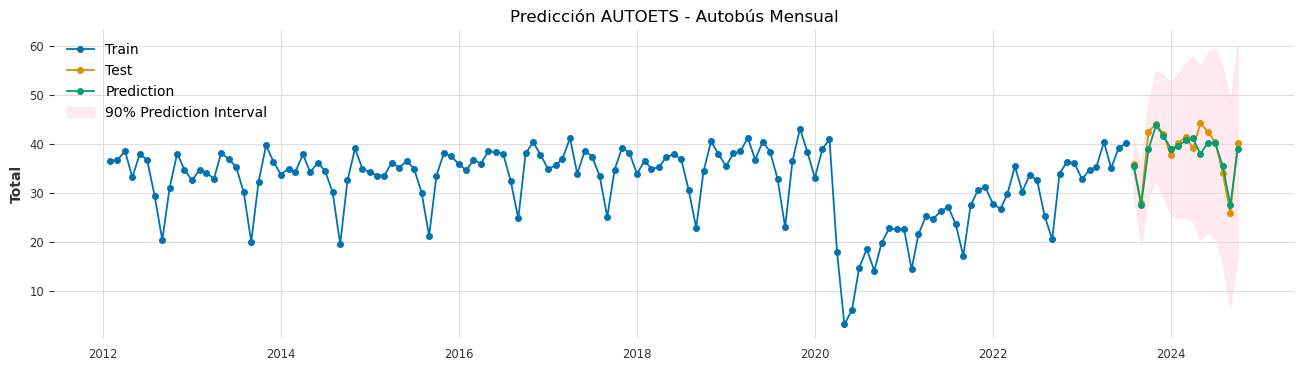

<Figure size 1400x700 with 0 Axes>

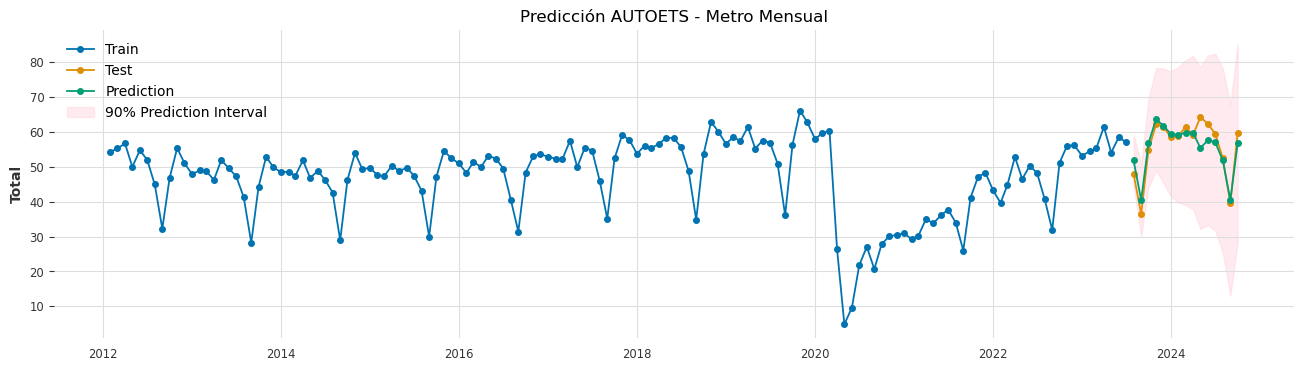

<Figure size 1400x700 with 0 Axes>

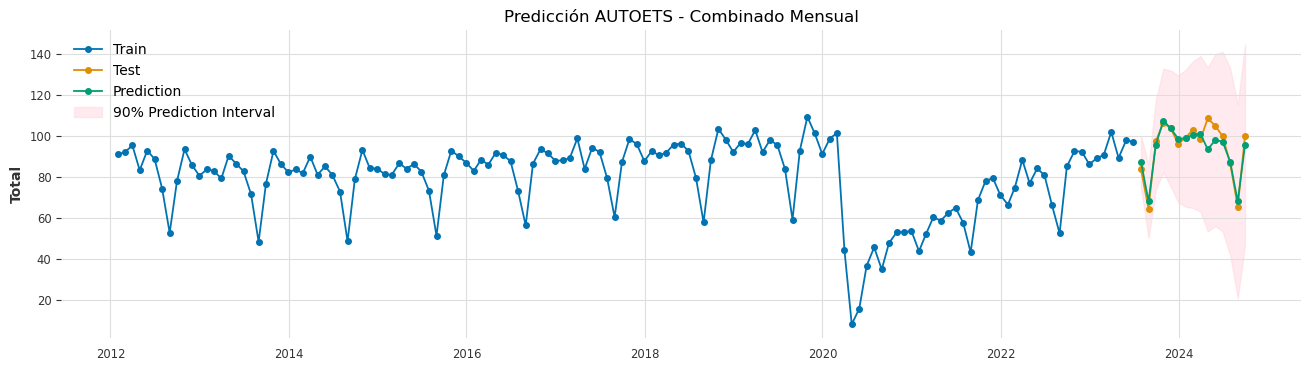

In [5]:
# Definir una función para realizar predicciones y graficar los resultados
def forecast_and_plot(series, title, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicción
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Obtener el intervalo de confianza al 90%
    y_pred_int = forecaster.predict_interval(fh, coverage=0.90)
    
    # Asegurarse de que las columnas 'lower' y 'upper' existan
    if 'lower' not in y_pred_int.columns or 'upper' not in y_pred_int.columns:
        y_pred_int.columns = ['lower', 'upper']
    
    # Graficar los resultados
    plt.figure(figsize=(14, 7))
    plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"])
    plt.fill_between(y_pred_int.index, y_pred_int["lower"], y_pred_int["upper"], color='pink', alpha=0.3, label="90% Prediction Interval")
    plt.title(title)
    plt.legend()
    plt.show()

# Realizar predicciones y graficar para cada dataframe mensual con sp=12 y test_size=15
forecast_and_plot(df_autobus_month, "Predicción AUTOETS - Autobús Mensual", sp=12, test_size=15)
forecast_and_plot(df_metro_month, "Predicción AUTOETS - Metro Mensual", sp=12, test_size=15)
forecast_and_plot(df_combined_month, "Predicción AUTOETS - Combinado Mensual", sp=12, test_size=15)

In [6]:
# Definir una función para realizar predicciones y calcular métricas
def forecast_and_calculate_metrics(series, sp, test_size):
    # Dividir los datos en entrenamiento y prueba
    y_train, y_test = temporal_train_test_split(series, test_size=test_size)
    
    # Definir el horizonte de predicción
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    # Crear y ajustar el modelo AutoETS
    forecaster = AutoETS(auto=True, sp=sp, n_jobs=-1)
    forecaster.fit(y_train)
    
    # Realizar predicciones
    y_pred = forecaster.predict(fh)
    
    # Calcular métricas
    mse = MeanSquaredError()(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    return mse, rmse, mape

# Calcular métricas para cada dataframe mensual
mse_autobus_month, rmse_autobus_month, mape_autobus_month = forecast_and_calculate_metrics(df_autobus_month, sp=12, test_size=15)
mse_metro_month, rmse_metro_month, mape_metro_month = forecast_and_calculate_metrics(df_metro_month, sp=12, test_size=15) 
mse_combined_month, rmse_combined_month, mape_combined_month = forecast_and_calculate_metrics(df_combined_month, sp=12, test_size=15)

# Mostrar resultados
print("Métricas para Autobús Mensual:")
print(f"MSE: {mse_autobus_month}, RMSE: {rmse_autobus_month}, MAPE: {mape_autobus_month}")

print("\nMétricas para Metro Mensual:")
print(f"MSE: {mse_metro_month}, RMSE: {rmse_metro_month}, MAPE: {mape_metro_month}")

print("\nMétricas para Combinado Mensual:")
print(f"MSE: {mse_combined_month}, RMSE: {rmse_combined_month}, MAPE: {mape_combined_month}")


Métricas para Autobús Mensual:
MSE: 4.718598852179303, RMSE: 2.1722336090253513, MAPE: 0.038964134894091666

Métricas para Metro Mensual:
MSE: 10.574237900366414, RMSE: 3.251805329408022, MAPE: 0.04355536794726542

Métricas para Combinado Mensual:
MSE: 23.827076473422597, RMSE: 4.881298646202934, MAPE: 0.03511846408082429


### Series trimestrales ETS

<Figure size 1400x700 with 0 Axes>

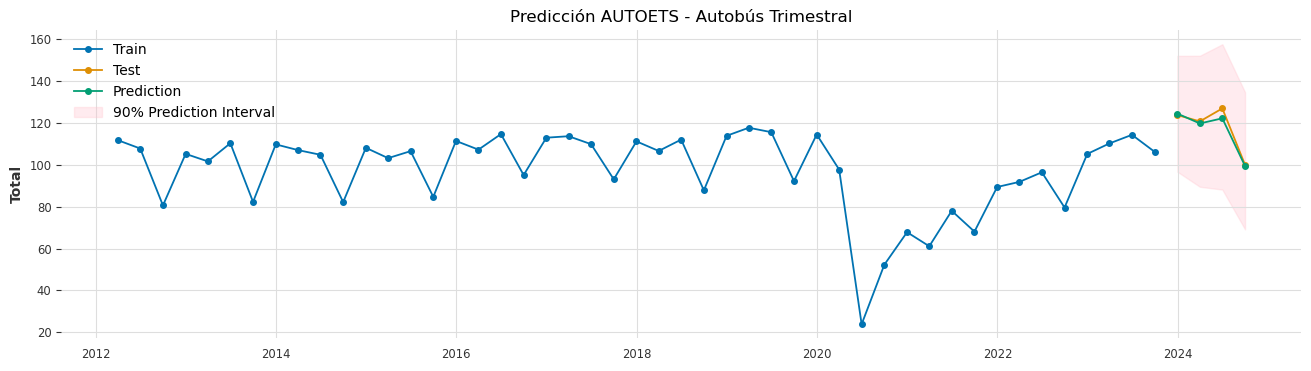

<Figure size 1400x700 with 0 Axes>

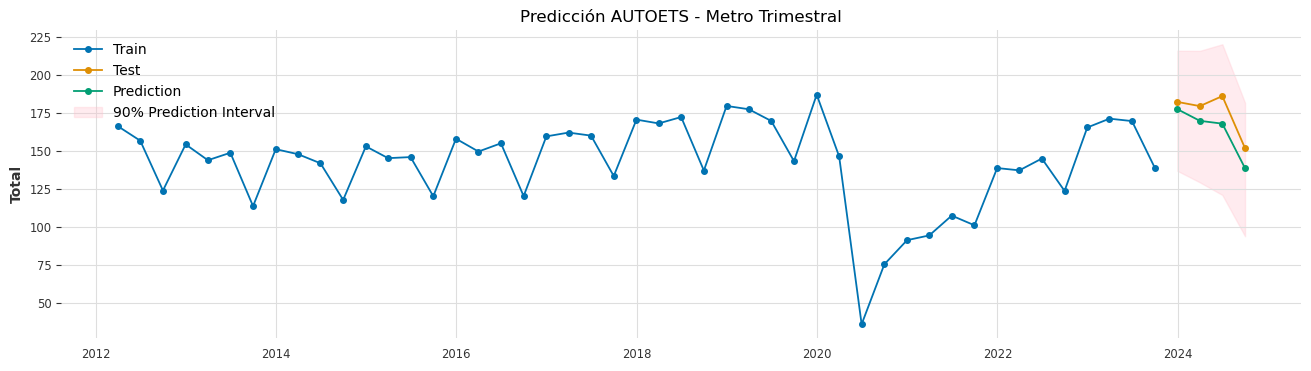

<Figure size 1400x700 with 0 Axes>

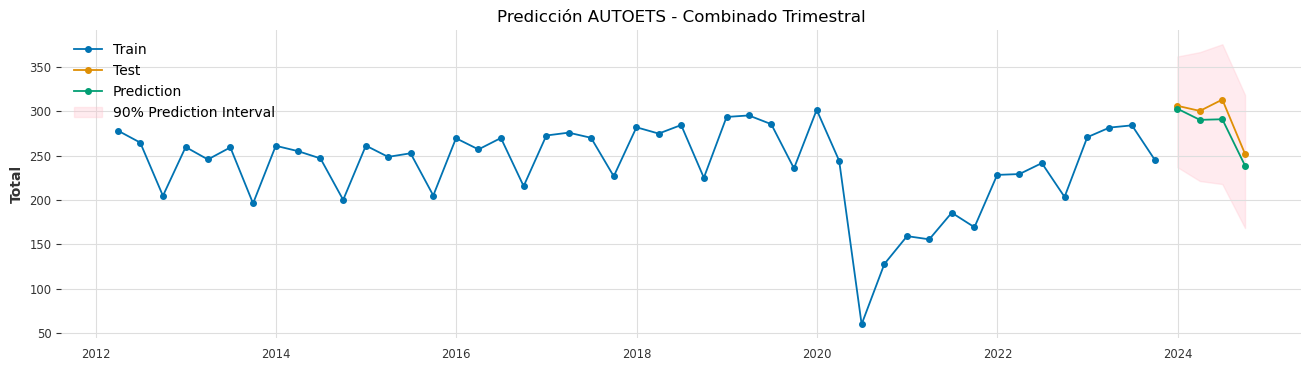

In [7]:
# Realizar predicciones y graficar para cada dataframe trimestral con sp=4 y test_size=8
forecast_and_plot(df_autobus_trim, "Predicción AUTOETS - Autobús Trimestral", sp=4, test_size=4)
forecast_and_plot(df_metro_trim, "Predicción AUTOETS - Metro Trimestral", sp=4, test_size=4)
forecast_and_plot(df_combined_trim, "Predicción AUTOETS - Combinado Trimestral", sp=4, test_size=4)

In [8]:
# Calcular métricas para cada dataframe trimestral
mse_autobus_trim, rmse_autobus_trim, mape_autobus_trim = forecast_and_calculate_metrics(df_autobus_trim, sp=4, test_size=4)
mse_metro_trim, rmse_metro_trim, mape_metro_trim = forecast_and_calculate_metrics(df_metro_trim, sp=4, test_size=4)
mse_combined_trim, rmse_combined_trim, mape_combined_trim = forecast_and_calculate_metrics(df_combined_trim, sp=4, test_size=4)
# Mostrar resultados
print("Métricas para Autobús Trimestral:")
print(f"MSE: {mse_autobus_trim}, RMSE: {rmse_autobus_trim}, MAPE: {mape_autobus_trim}")

print("\nMétricas para Metro Trimestral:")
print(f"MSE: {mse_metro_trim}, RMSE: {rmse_metro_trim}, MAPE: {mape_metro_trim}")

print("\nMétricas para Combinado Trimestral:")
print(f"MSE: {mse_combined_trim}, RMSE: {rmse_combined_trim}, MAPE: {mape_combined_trim}")


Métricas para Autobús Trimestral:
MSE: 6.041031249196908, RMSE: 2.4578509412079708, MAPE: 0.014211584720710659

Métricas para Metro Trimestral:
MSE: 153.83868163959468, RMSE: 12.40317224098717, MAPE: 0.06590390395338475

Métricas para Combinado Trimestral:
MSE: 194.2642574724126, RMSE: 13.937871339354967, MAPE: 0.041847361695736864


***
## Theta Model

El modelo Theta es un enfoque estadístico diseñado específicamente para la predicción de series temporales, basado en una descomposición y transformación innovadora. Su funcionamiento se centra en la modificación de la segunda derivada de la serie original mediante un parámetro conocido como "Theta", lo que permite alterar la curvatura de la serie para destacar diferentes componentes, como la tendencia o la estacionalidad. Generalmente, el modelo combina dos series transformadas: una captura la tendencia a largo plazo y otra enfatiza patrones estacionales y ruido a corto plazo. A continuación, se aplican métodos como la suavización exponencial o regresión lineal a las series transformadas. Finalmente, las predicciones de las series Theta ajustadas se combinan linealmente para obtener el pronóstico final. Esta técnica es especialmente efectiva en series con patrones suaves o estacionales, mostrando robustez y precisión en diversos contextos.

### Series mensuales Theta

In [9]:
df_autobus_month_ts = TimeSeries.from_series(df_autobus_month)
df_autobus_trim_ts = TimeSeries.from_series(df_autobus_trim)
df_combined_month_ts = TimeSeries.from_series(df_combined_month)
df_combined_trim_ts = TimeSeries.from_series(df_combined_trim)
df_metro_month_ts = TimeSeries.from_series(df_metro_month)
df_metro_trim_ts = TimeSeries.from_series(df_metro_trim)

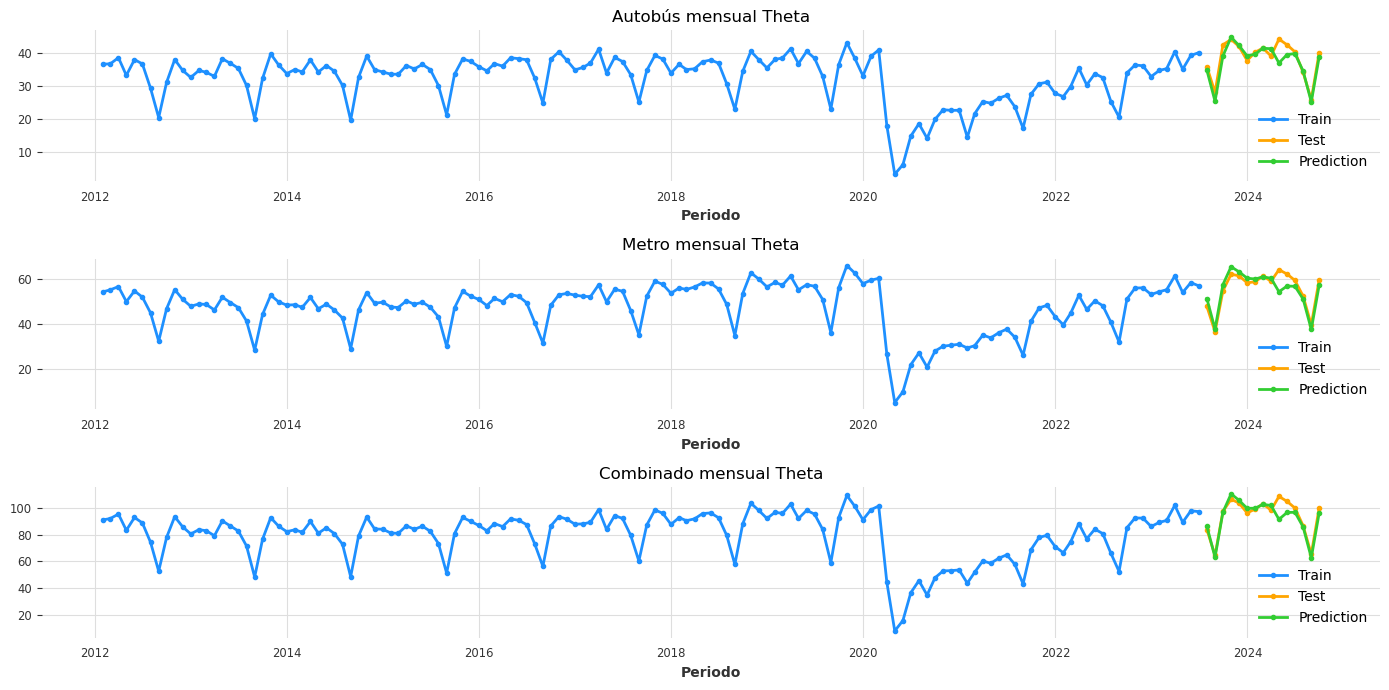

In [21]:
# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus, test_autobus = df_autobus_month_ts[:-15], df_autobus_month_ts[-15:]
train_metro, test_metro = df_metro_month_ts[:-15], df_metro_month_ts[-15:]
train_combined, test_combined = df_combined_month_ts[:-15], df_combined_month_ts[-15:]

# Crear y entrenar el modelo Theta
theta_model = Theta(seasonality_period=12)

# Entrenar el modelo con los datos de autobús
theta_model.fit(train_autobus)
pred_autobus = theta_model.predict(len(test_autobus))

# Entrenar el modelo con los datos de metro
theta_model.fit(train_metro)
pred_metro = theta_model.predict(len(test_metro))

# Entrenar el modelo con los datos combinados
theta_model.fit(train_combined)
pred_combined = theta_model.predict(len(test_combined))

# Graficar los resultados
plt.figure(figsize=(14, 7))

# Graficar los datos de autobús
plt.subplot(3, 1, 1)
train_autobus.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_autobus.plot(label='Test', color='orange', marker='o', markersize=3)
pred_autobus.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Autobús mensual Theta')
plt.legend()

# Graficar los datos de metro
plt.subplot(3, 1, 2)
train_metro.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_metro.plot(label='Test', color='orange', marker='o', markersize=3)
pred_metro.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Metro mensual Theta')
plt.legend()

# Graficar los datos combinados
plt.subplot(3, 1, 3)
train_combined.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_combined.plot(label='Test', color='orange', marker='o', markersize=3)
pred_combined.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Combinado mensual Theta')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
def calculate_metrics(test, pred):
    mse_value = mse(test, pred)
    rmse_value = rmse(test, pred)
    mape_value = mape(test, pred)
    return mse_value, rmse_value, mape_value

# Calcular métricas para las predicciones de autobús
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(test_autobus, pred_autobus)

# Calcular métricas para las predicciones de metro
mse_metro, rmse_metro, mape_metro = calculate_metrics(test_metro, pred_metro)

# Calcular métricas para las predicciones combinadas
mse_combined, rmse_combined, mape_combined = calculate_metrics(test_combined, pred_combined)

print("Métricas para Autobús Mensual:")
print(f"MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")

print("\nMétricas para Metro Mensual:")
print(f"MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

print("\nMétricas para Combinado Mensual:")
print(f"MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")

Métricas para Autobús Mensual:
MSE: 6.111005318196414, RMSE: 2.472044764602052, MAPE: 4.3804097426450745

Métricas para Metro Mensual:
MSE: 12.520550345210069, RMSE: 3.5384389701123955, MAPE: 4.8271719731139155

Métricas para Combinado Mensual:
MSE: 29.8722117232718, RMSE: 5.465547705699018, MAPE: 3.707616743801179


### Series trimestrales Theta

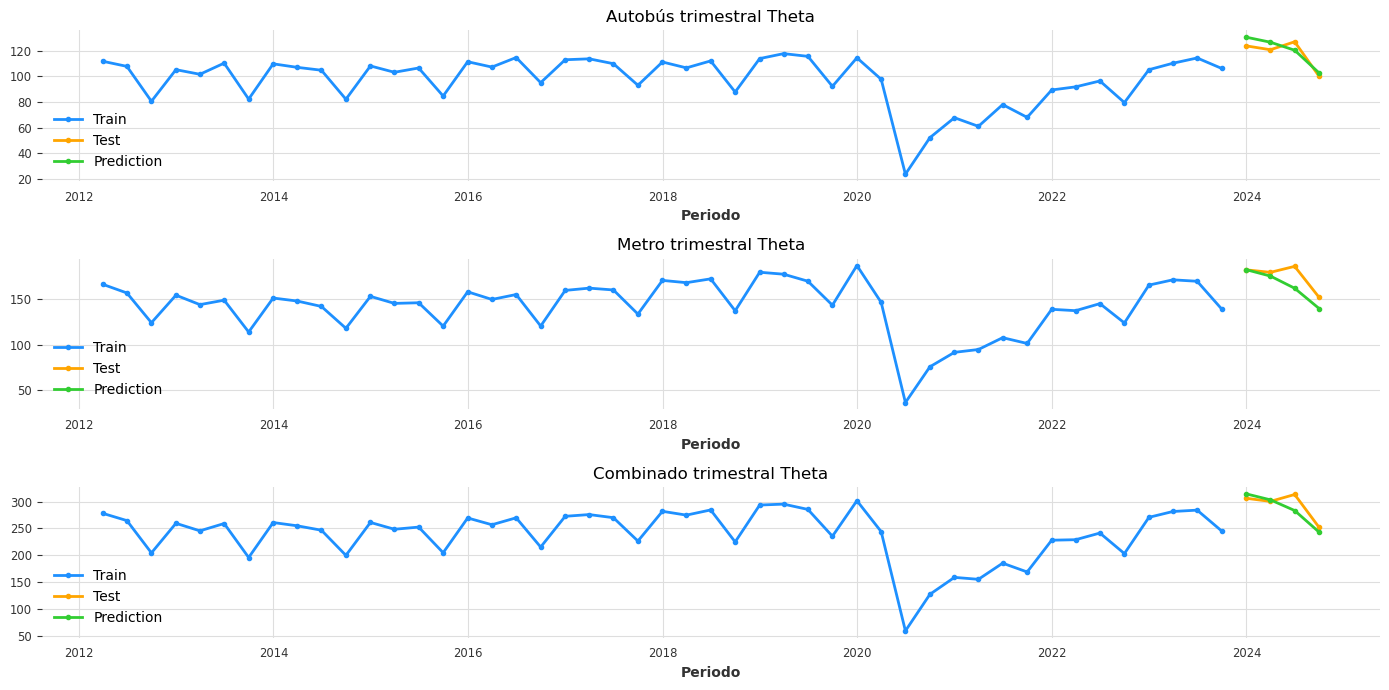

In [23]:
# Separar los datos en conjuntos de entrenamiento y prueba
train_autobus, test_autobus = df_autobus_trim_ts[:-4], df_autobus_trim_ts[-4:]
train_metro, test_metro = df_metro_trim_ts[:-4], df_metro_trim_ts[-4:]
train_combined, test_combined = df_combined_trim_ts[:-4], df_combined_trim_ts[-4:]

# Crear y entrenar el modelo Theta
theta_model = Theta(seasonality_period=4)

# Entrenar el modelo con los datos de autobús
theta_model.fit(train_autobus)
pred_autobus = theta_model.predict(len(test_autobus))

# Entrenar el modelo con los datos de metro
theta_model.fit(train_metro)
pred_metro = theta_model.predict(len(test_metro))

# Entrenar el modelo con los datos combinados
theta_model.fit(train_combined)
pred_combined = theta_model.predict(len(test_combined))

# Graficar los resultados
plt.figure(figsize=(14, 7))

# Graficar los datos de autobús
plt.subplot(3, 1, 1)
train_autobus.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_autobus.plot(label='Test', color='orange', marker='o', markersize=3)
pred_autobus.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Autobús trimestral Theta')
plt.legend()

# Graficar los datos de metro
plt.subplot(3, 1, 2)
train_metro.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_metro.plot(label='Test', color='orange', marker='o', markersize=3)
pred_metro.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Metro trimestral Theta')
plt.legend()

# Graficar los datos combinados
plt.subplot(3, 1, 3)
train_combined.plot(label='Train', color='dodgerblue', marker='o', markersize=3)
test_combined.plot(label='Test', color='orange', marker='o', markersize=3)
pred_combined.plot(label='Prediction', color='limegreen', marker='o', markersize=3)
plt.title('Combinado trimestral Theta')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Calcular métricas para las predicciones de autobús
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(test_autobus, pred_autobus)

# Calcular métricas para las predicciones de metro
mse_metro, rmse_metro, mape_metro = calculate_metrics(test_metro, pred_metro)

# Calcular métricas para las predicciones combinadas
mse_combined, rmse_combined, mape_combined = calculate_metrics(test_combined, pred_combined)

print("Métricas para Autobús Trimestral:")
print(f"MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")

print("\nMétricas para Metro Trimestral:")
print(f"MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

print("\nMétricas para Combinado Trimestral:")
print(f"MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")

Métricas para Autobús Trimestral:
MSE: 32.609415789087436, RMSE: 5.710465461684138, MAPE: 4.53129553312913

Métricas para Metro Trimestral:
MSE: 186.5564606272127, RMSE: 13.658567297751718, MAPE: 5.845973038968093

Métricas para Combinado Trimestral:
MSE: 259.47263135027555, RMSE: 16.10815418818294, MAPE: 4.156256524555424


***

## Predicciones finales con ETS

Tras un análisis exhaustivo de los modelos ETS y Theta aplicados a la predicción de pasajeros del transporte público de Madrid, se llevó a cabo una evaluación detallada tanto visual como cuantitativa. En el aspecto visual, las predicciones del modelo ETS mostraron un ajuste más preciso a los datos históricos, capturando con mayor fidelidad los patrones de tendencia y estacionalidad característicos de la demanda de transporte en la ciudad, sobre todo en las series trimestrales.

Desde el punto de vista de las métricas, el modelo ETS presentó ligeramente mejores resultados en el Error Cuadrático Medio (MSE), la Raíz del Error Cuadrático Medio (RMSE) y el Error Absoluto Medio Porcentual (MAPE). Estas métricas indican una menor desviación entre los valores reales y los predichos, lo que sugiere una mayor precisión y robustez en las predicciones del modelo ETS frente al modelo Theta.

Considerando tanto el desempeño cuantitativo como cualitativo, se ha determinado que el modelo ETS es el más adecuado para este problema. Por ello, se selecciona como el modelo definitivo para realizar las predicciones finales, asegurando una mayor confiabilidad en la estimación de la demanda futura de pasajeros del sistema de transporte público de Madrid. Este enfoque permitirá respaldar decisiones informadas en la planificación y gestión del transporte urbano.

In [25]:
df_combined_month.tail()

2024-05-31    104.789
2024-06-30     99.773
2024-07-31     86.524
2024-08-31     65.379
2024-09-30     99.955
Freq: ME, Name: Total, dtype: float64

### Predicción final de la serie mensual con ETS

<Figure size 1400x700 with 0 Axes>

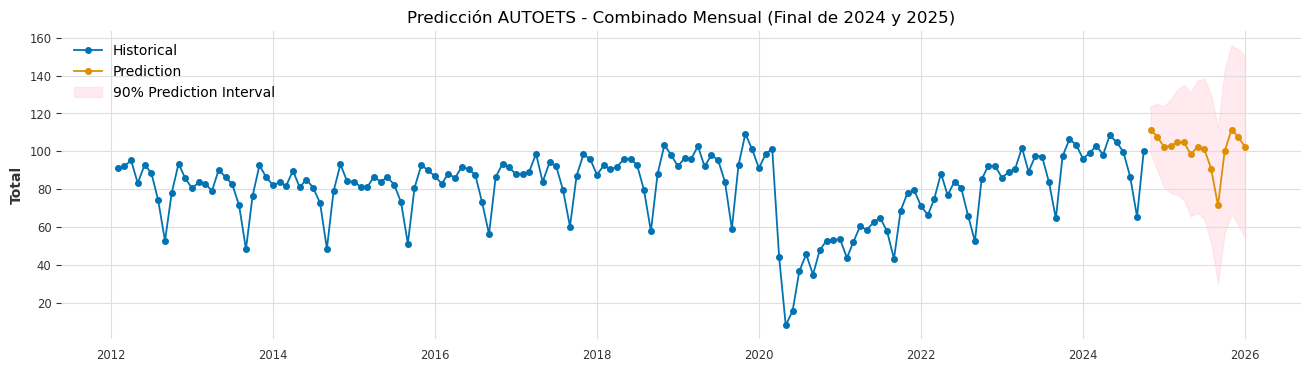

In [26]:
# Definir el horizonte de predicción para los próximos 15 meses
fh_future = ForecastingHorizon(pd.date_range(start='2024-10-31', periods=15, freq='M'), is_relative=False)

# Crear y ajustar el modelo AutoETS con los datos completos
forecaster_combined = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster_combined.fit(df_combined_month)

# Realizar predicciones para los próximos 15 meses
y_pred_combined_future = forecaster_combined.predict(fh_future)

# Obtener el intervalo de confianza al 90%
y_pred_combined_future_int = forecaster_combined.predict_interval(fh_future, coverage=0.90)

# Asegurarse de que las columnas 'lower' y 'upper' existan
if 'lower' not in y_pred_combined_future_int.columns or 'upper' not in y_pred_combined_future_int.columns:
    y_pred_combined_future_int.columns = ['lower', 'upper']

# Graficar los resultados
plt.figure(figsize=(14, 7))
plot_series(df_combined_month, y_pred_combined_future, labels=["Historical", "Prediction"])
plt.fill_between(y_pred_combined_future_int.index, y_pred_combined_future_int["lower"], y_pred_combined_future_int["upper"], color='pink', alpha=0.3, label="90% Prediction Interval")
plt.title("Predicción AUTOETS - Combinado Mensual (Final de 2024 y 2025)")
plt.legend()
plt.show()

In [27]:
y_pred_combined_future

2024-10-31    111.445272
2024-11-30    107.631177
2024-12-31    102.334498
2025-01-31    102.824450
2025-02-28    104.741913
2025-03-31    104.706983
2025-04-30     98.461919
2025-05-31    102.352472
2025-06-30    101.262752
2025-07-31     90.858175
2025-08-31     71.331870
2025-09-30     99.954405
2025-10-31    111.445272
2025-11-30    107.631177
2025-12-31    102.334498
Freq: ME, Name: Total, dtype: float64

### Predicción final de la serie trimestral con ETS

In [28]:
df_combined_trim.tail()

2023-09-30    245.395
2023-12-31    306.020
2024-03-31    300.261
2024-06-30    313.032
2024-09-30    251.858
Freq: QE-DEC, Name: Total, dtype: float64

<Figure size 1400x700 with 0 Axes>

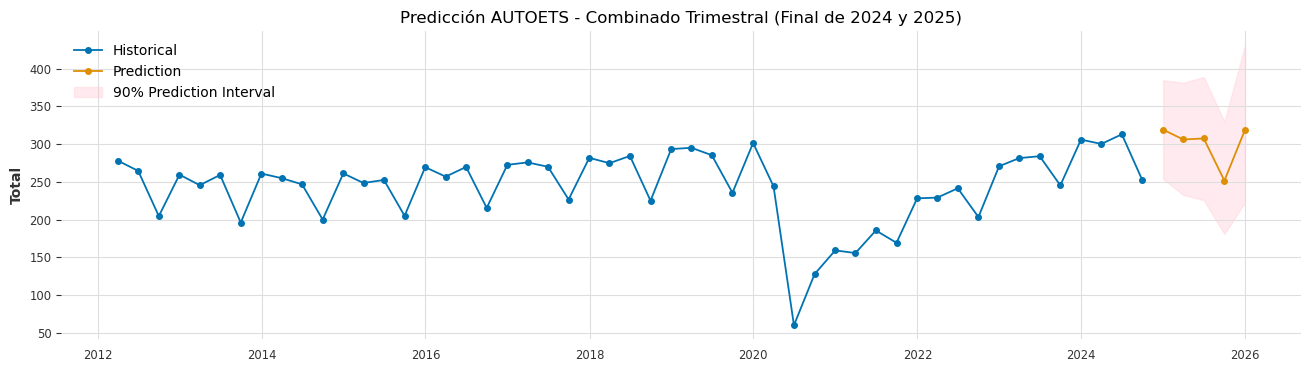

In [29]:
# Definir el horizonte de predicción para los próximos 5 trimestres
fh_future_trim = ForecastingHorizon(pd.date_range(start='2024-12-31', periods=5, freq='Q'), is_relative=False)

# Crear y ajustar el modelo AutoETS con los datos completos
forecaster_combined_trim = AutoETS(auto=True, sp=4, n_jobs=-1)
forecaster_combined_trim.fit(df_combined_trim)

# Realizar predicciones para los próximos 5 trimestres
y_pred_combined_trim_future = forecaster_combined_trim.predict(fh_future_trim)

# Obtener el intervalo de confianza al 90%
y_pred_combined_trim_future_int = forecaster_combined_trim.predict_interval(fh_future_trim, coverage=0.90)

# Asegurarse de que las columnas 'lower' y 'upper' existan
if 'lower' not in y_pred_combined_trim_future_int.columns or 'upper' not in y_pred_combined_trim_future_int.columns:
    y_pred_combined_trim_future_int.columns = ['lower', 'upper']

# Graficar los resultados
plt.figure(figsize=(14, 7))
plot_series(df_combined_trim, y_pred_combined_trim_future, labels=["Historical", "Prediction"])
plt.fill_between(y_pred_combined_trim_future_int.index, y_pred_combined_trim_future_int["lower"], y_pred_combined_trim_future_int["upper"], color='pink', alpha=0.3, label="90% Prediction Interval")
plt.title("Predicción AUTOETS - Combinado Trimestral (Final de 2024 y 2025)")
plt.legend()
plt.show()

In [30]:
y_pred_combined_trim_future

2024-12-31    319.130843
2025-03-31    306.152603
2025-06-30    307.551548
2025-09-30    251.639130
2025-12-31    319.130843
Freq: QE-DEC, Name: Total, dtype: float64

### Guardamos las predicciones

In [31]:
y_pred_combined_future.to_csv('../data/Madrid_combined_month_forecast.csv')
y_pred_combined_trim_future.to_csv('../data/Madrid_combined_trim_forecast.csv')

***
## Conclusión Final

A lo largo de este estudio, se llevó a cabo un exhaustivo análisis de diversos modelos de predicción aplicados a la serie temporal de pasajeros del transporte público de Madrid. Se probaron y evaluaron tanto modelos estadísticos clásicos (ARIMA, ETS, Theta, CES, BATS, TBATS, Prophet, BSTS, Causal Impact) como modelos avanzados de machine learning (Decision Tree, XGBoost, LightGBM, Random Forest y KNN). Cada modelo fue ajustado utilizando técnicas de ajuste de hiperparámetros y validación cruzada, con el objetivo de maximizar su capacidad predictiva y asegurar un enfoque riguroso y reproducible.

La evaluación se realizó mediante la graficación de las predicciones con sus intervalos de confianza y el cálculo de métricas clave: el Error Cuadrático Medio (MSE), la Raíz del Error Cuadrático Medio (RMSE) y el Error Absoluto Medio Porcentual (MAPE). Estas métricas permitieron comparar el desempeño de los modelos de manera objetiva y cuantitativa. Si bien varios modelos presentaron resultados competitivos, los modelos ETS y Theta destacaron significativamente por su capacidad de capturar los patrones de tendencia y estacionalidad inherentes a los datos de transporte público.

Finalmente, el modelo ETS se consolidó como la mejor opción al ofrecer el ajuste más preciso y consistente a la serie temporal, demostrando su robustez en el modelado de series con estacionalidad regular y tendencias claras. Su desempeño superior tanto en métricas como en análisis visual justifica su selección para realizar las predicciones finales de pasajeros.

El proceso de selección y evaluación no solo permitió identificar el modelo óptimo, sino que también representó una valiosa oportunidad de aprendizaje. La integración de técnicas estadísticas y de machine learning, el uso de métodos avanzados como la validación cruzada, y el ajuste fino de hiperparámetros enriquecieron los conocimientos adquiridos en el modelado de series temporales y en la aplicación de herramientas analíticas para resolver problemas reales.

En el informe económico a redactar, se expondrá la problemática de negocio asociada a la fluctuación y previsión de la demanda de pasajeros en el transporte público de Madrid. Además, se propondrán estrategias basadas en las predicciones generadas por el modelo ETS para optimizar recursos, mejorar la experiencia de los usuarios y fomentar una planificación más eficiente de los servicios. Este trabajo destaca el potencial del análisis de datos y la modelización predictiva para abordar desafíos estratégicos en contextos urbanos complejos.